# Medical Label Project

## Setting up

Import necessary packages and adjust settings.

In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.options.mode.chained_assignment = None  # default='warn'

Read data from csv files.

In [287]:
reads = pd.read_csv('data/1345_admin_reads.csv')
results = pd.read_csv('data/1345_customer_results.csv',index_col="Case ID")

Throw out all rows which do not end with voteN for N=0-8 in the "Origin" column of the results dataframe, and extract N from the column for the remaining data.\
N is the number of experts who voted 'yes'.

In [288]:
valid_vote = results["Origin"].str.fullmatch(r'(.*)vote[0-8](.*)', case=False)
valid_results = results.loc[valid_vote]
votes = valid_results["Origin"].str.extract(r'vote(\d)').astype(int)

Throw out unnecessary columns. Create a new row called "Votes" to store the number of votes extracted from the "Origin".

In [289]:
reads=reads.loc[:,["problem_id", "accuracy","chosen_answer"]]
reads["chosen_answer"]=reads["chosen_answer"].str.extract(r'\[(.*)\]')
valid_results = valid_results.loc[:,"Qualified Reads":"Second Choice Weight"]
valid_results["Votes"] = votes
reads

,problem_id,accuracy,chosen_answer
0,5888087,0.78,'no'
1,5888087,0.76,'no'
2,5888088,0.78,'no'
3,5888088,0.80,'no'
4,5888088,0.76,'no'
...,...,...,...
152055,5918379,0.82,'yes'
152056,5918379,0.78,'yes'
152057,5918379,0.84,'yes'
152058,5918379,0.76,'yes'


## Remarks on "Correct Label"

By interpreting number of votes<4 as having a correct label of 'no', number of votes>4 as having a correct label of 'yes', and having no correct label otherwise, this column completely agrees with the "Correct Label" column.

In [290]:
print("Correct Labels corresponding to < 4 votes:", valid_results.loc[valid_results["Votes"]<4,"Correct Label"].unique())
print("Correct Labels corresponding to > 4 votes:", valid_results.loc[valid_results["Votes"]>4,"Correct Label"].unique())
print("Correct Labels corresponding to = 4 votes:", valid_results.loc[valid_results["Votes"]==4,"Correct Label"].unique())

Correct Labels corresponding to < 4 votes: ["'no'"]
Correct Labels corresponding to > 4 votes: ["'yes'"]
Correct Labels corresponding to = 4 votes: [nan]


We also note that out of the 27000 results, 12000 of them have a correct label of 'no', 12000 of them have a correct label of 'yes', and 3000 of them have no correct label.

In [291]:
print(valid_results["Correct Label"].value_counts(dropna=False))

'no'     12000
'yes'    12000
NaN       3000
Name: Correct Label, dtype: int64


## Remark on "Majority Label"

Out of the 27000 results, 14547 of them have a majority label of 'no', 12211 of them have a majority label of 'yes', and 242 of them have no majority label.

In [292]:
print(valid_results["Majority Label"].value_counts(dropna=False))

'yes'    14547
'no'     12211
NaN        242
Name: Majority Label, dtype: int64


The reason that 242 of them have no majority labels is that all of them have no qualified reads.

In [293]:
print(valid_results.loc[valid_results["Majority Label"].isna(),"Qualified Reads"].value_counts())

0    242
Name: Qualified Reads, dtype: int64


Of the results with at least one qualified reads, 1580 of them have an equal number of yes/no votes. In these cases, the majority label is determined by the sum of accuracy score of qualified reads for each choice answer.

In [294]:
print(valid_results.loc[(valid_results["First Choice Votes"]==valid_results["Second Choice Votes"])&(valid_results["Qualified Reads"]!=0),"Majority Label"].value_counts(dropna=False))

'no'     764
'yes'    744
Name: Majority Label, dtype: int64


## Analysis

We first count the number of expert who agrees with expert majority and the total number of expert votes.\
The since each result have 8 expert votes, the total number is simply calculated by 8 times the number of results.\
The problem is that as we've seen earlier, some results have no expert majority because equal number of experts voted on yes vs no, so we need to decide whether to include these results. I'd like to argue that since there have to be a correct label (though we don't know which), we can say that 50% of the experts got the correct answer in these cases, so the result can be included.\
Then the number is calculated by summing over the number of votes on the majority label.

In [295]:
num_expert_agree = (np.max((valid_results["Votes"],8-valid_results["Votes"]),axis=0)).sum()
total_expert_votes = len(valid_results.index) * 8
num_expert_agree/total_expert_votes

0.7777777777777778

Then we do the same for the crowd votes.\
Note that there are some cases where the first choice answer is not the same as majority label since there were an equal number of first choice answers and second choice answers, but we can safely use the number of votes on the first choice answer in our calculation of votes that agreed with the correct label since the votes on the two answers are the same.

In [296]:
total_crowd_votes = (valid_results["Qualified Reads"]).sum()

# Descriptive Analysis
We will try to prove that the crowd agree with the expert majority more often than experts agreeing with the expert majority.

First we look at how often crowd agrees with each other. The plot below show the box plot of crowd agreement rate grouped by expert agreement rate. We can see that the mean agreement of crowd among themselves is around 80% even for cases where experts largely disagree with each other, and have slightly higher agreement rate for cases where experts also have high agreement.

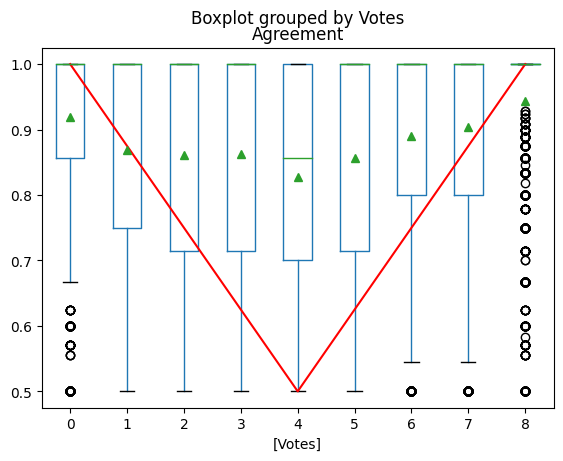

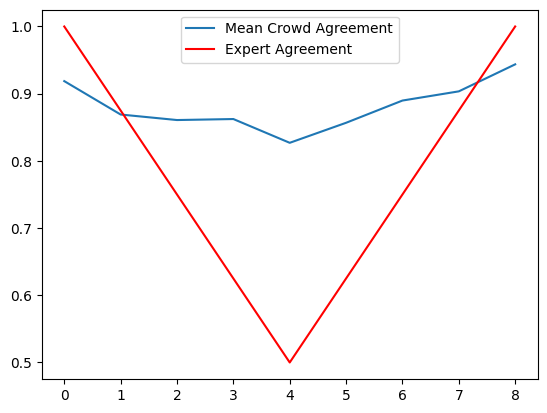

In [297]:
valid_results[["Agreement","Votes"]].boxplot(by="Votes", showmeans=True, grid=False)
expert_agreement=np.max([1-np.arange(0,1.01,1/8), np.arange(0,1.01,1/8)],axis=0)
plt.plot(np.arange(9)+1, expert_agreement, color="r")
plt.show()
plt.plot(valid_results.groupby("Votes")[["Agreement"]].mean(),label="Mean Crowd Agreement")
plt.plot(np.arange(9), expert_agreement,label="Expert Agreement", color="r")
plt.legend()
plt.show()

Now we find how often crowd agrees with expert majority.\
Here we make a new column to store the agreement rate between crowd and expert majority. If the crowd gives the same label as expert majority does, then the agreement rate is left as it is, if the crowd disagrees with expert majority, then the rate is 1 minus the agreement rate among the crowd. In the case that there's no agreement among experts, we assume the crowd agreed with the expert majority.

In [298]:
agreement = ((valid_results["Majority Label"]==valid_results["Correct Label"]) | (valid_results["Correct Label"].isna()))
valid_results["Agreement With Expert"] = valid_results["Agreement"]*agreement+(1-valid_results["Agreement"])*(1 - agreement)

As we can see in the plots below, most of the mean agreement rate drops below the agreement rate among experts, but the medians remains high.

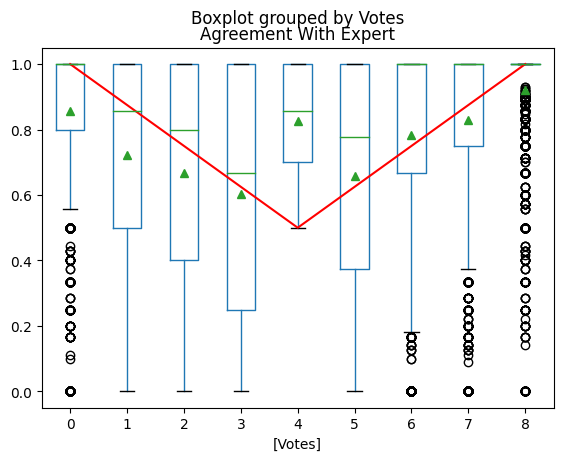

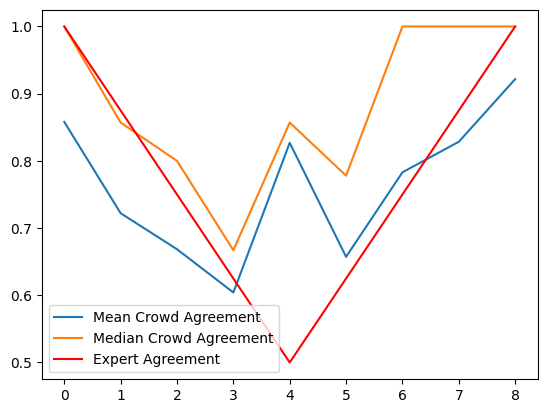

In [299]:
valid_results[["Agreement With Expert","Votes"]].boxplot(by="Votes", showmeans=True, grid=False)
plt.plot(np.arange(9)+1, expert_agreement, color="r")
plt.show()
plt.plot(valid_results.groupby("Votes")[["Agreement With Expert"]].mean(),label="Mean Crowd Agreement")
plt.plot(valid_results.groupby("Votes")[["Agreement With Expert"]].median(),label="Median Crowd Agreement")
plt.plot(np.arange(9), expert_agreement,label="Expert Agreement", color="r")
plt.legend()
plt.show()

The current agreement rate does not take account into the accuracy of labelers, so we can add weight to the votes on labels based on accuracy.

In [300]:
weighted_agreement = (valid_results["First Choice Votes"]*valid_results["First Choice Weight"])/(valid_results["First Choice Votes"]*valid_results["First Choice Weight"]+valid_results["Second Choice Votes"]*valid_results["Second Choice Weight"])
valid_results["Weighted Agreement"] = weighted_agreement*agreement + (1-weighted_agreement)*(1-agreement)

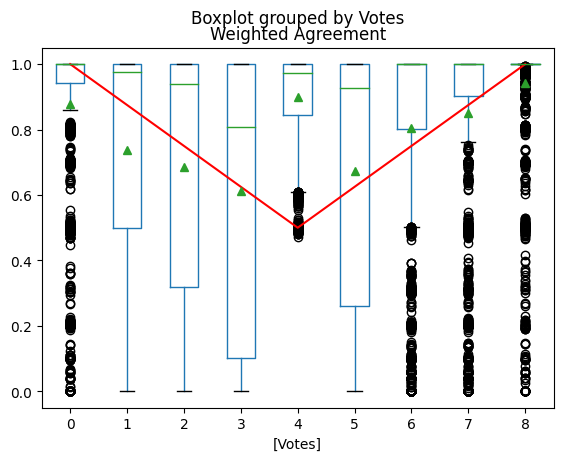

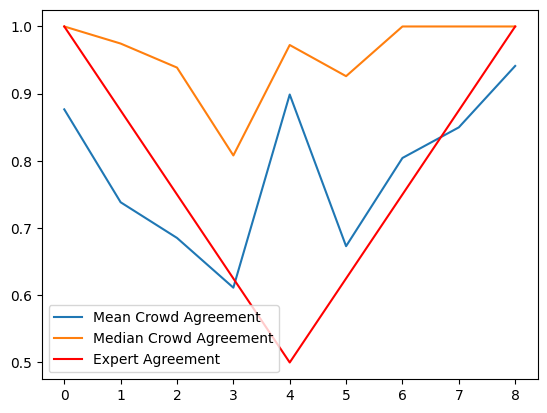

In [301]:
valid_results[["Weighted Agreement","Votes"]].boxplot(by="Votes", showmeans=True, grid=False)
plt.plot(np.arange(9)+1, expert_agreement, color="r")
plt.show()
plt.plot(valid_results.groupby("Votes")[["Weighted Agreement"]].mean(),label="Mean Crowd Agreement")
plt.plot(valid_results.groupby("Votes")[["Weighted Agreement"]].median(),label="Median Crowd Agreement")
plt.plot(np.arange(9), expert_agreement,label="Expert Agreement", color="r")
plt.legend()
plt.show()

In [310]:
weighted = reads.groupby(["problem_id","chosen_answer"]).agg(pd.Series.sum)
weighted.reset_index(["problem_id","chosen_answer"], inplace=True)
joined_result = valid_results.join(weighted.set_index("problem_id"),on="Case ID")

In [313]:
weighted_acc = joined_result.groupby(["Case ID","Votes"])[["accuracy"]].agg((pd.Series.sum,pd.Series.max)).reset_index(["Case ID","Votes"])
weighted_acc["agreement"] = weighted_acc["accuracy"]["max"]/weighted_acc["accuracy"]["sum"]
weighted_acc.columns = weighted_acc.columns.droplevel(1)

In [314]:
acc = weighted_acc["agreement"]
weighted_acc["Weighted Agreement"] = weighted_agreement*agreement + (1-weighted_agreement)*(1-agreement)

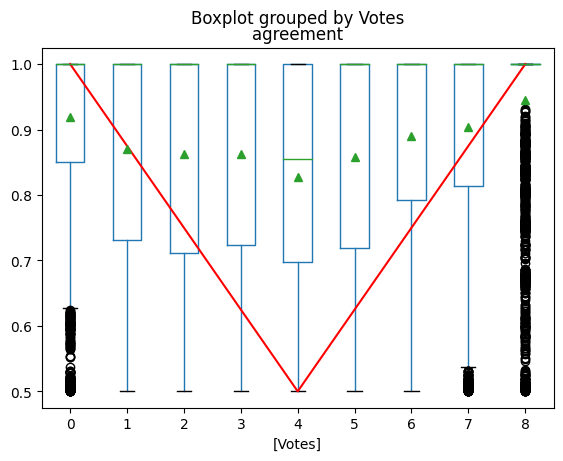

In [319]:
weighted_acc[["agreement","Votes"]].boxplot(by="Votes", showmeans=True, grid=False)
plt.plot(np.arange(9)+1, expert_agreement, color="r")
plt.show()

In [318]:
acc

0        1.000000
1        1.000000
2        1.000000
3        1.000000
4        0.585714
           ...   
26995    1.000000
26996    0.672414
26997    1.000000
26998         NaN
26999    0.808081
Name: agreement, Length: 27000, dtype: float64